<a href="https://colab.research.google.com/github/SubhashreeDutta/CISHack-UITBU/blob/main/TechTitans_(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model to filter out False Positive generated by Alert system.

## Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

## Predicting True Positive from Fraudlent Transactions:

We are presented with a labeled dataset of financial transactions, some of which are case of money laundering. We will be performing exploratory data analysis on this data, and then creating a classifier model to predict whether a transaction is real alert or not, given the included features. The objective of this project is to explain my thought processes in solving this problem, as well as addressing some of the issues that inherently face machine learning models. ("All models are wrong, but some are useful.") Using this notebook, I hope to focus primarily on transparency and clarity rather than raw predictive performance, and readability for an audience without a specialization in data science.

'Note:' Here whenever we talk about fraud or fraudulent, it means alert system marked it as Money laundering. 

### 1. Data Input and EDA

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

The data has about 6.3 million rows and 11 columns. Each row represents a transaction.

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Correcting inconsistency in column name
df = df.rename(columns={'oldbalanceOrg':'oldbalanceOrig'})

#### Columns are:
* step: A timestamp / date variable that has been made arbitrary for data privacy.

* type: The type of transaction. type is our only categorical independent variable. Categories include [cash_in, cash_out, debit, payment, transfer].

* amount: Size of transaction.


Next 6 columns are account level info:

* Suffix *Orig refers to the originating account of the transaction.

* Suffix *Dest refers to destination account of the transaction.

* Prefix name* refers to Account ID number. An 'M' prefix, e.g. 'M1979...' denotes a merchant account. The name will not be directly used as a model feature, although we can extract the merchant prefix to create a boolean indicator variable. One thing to note is that balance data is not available for merchants. For merchants, the placeholder value for balances is zero.

* Prefix oldbalance* refers to account balance before transaction.

* Prefix newbalance* refers to account balance after transaction (and also great pair of shoes!)

* isFraud: Our label / dependent variable—whether the transaction was made by a fraudulent agent. 1 for fraudulent, 0 for not fraudulent.

* isFlaggedFraud: Whether the transaction was flagged as fraud by the "business model". Since we are doing our own prediction here, we will ignore this variable

'NOTE:' - Here Fraudulent means it is a case of Money Laundering or not.

### Nulls

We have no nulls in the table. This will save us the headache of having to fill in or impute missing values, or otherwise exclude incomplete data rows, if required by the model.

In [ ]:
df.isnull().values.any()

False

### Data Imbalance

As is often the case with fraud data like this, the dataset is highly imbalanced. Over 99.8% of the transaction records are non-fraudulent. Because only a tiny fraction of the dataset represents fraud, fraudulent transactions are likely to be under-represented in our model. If unaddressed, data imbalance can cause issues, such as misleading accuracy metrics in the model. The model may attempt to label every transaction as non-fraudulent, and since any randomly given transaction is highly likely to be non-fraudulent, a high accuracy will be reported, despite incorrectly classifying all fraudulent transactions as non-fraudulent. We should take care to compare model performance metrics considering fraudulent and non-fraudulent data independently.

In [ ]:
print('The proportion of total transactions labeled as fraudulent is',df['isFraud'].value_counts()[1]/df['isFraud'].size)

The proportion of total transactions labeled as fraudulent is 0.001290820448180152


In [ ]:
df['isFraud'].value_counts().plot(kind='bar')

In [ ]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Features

Let's look at frequency plots for the feature variables.


#### (i). step

step is our time variable. Most transactions occur in the first half of our time sample range.

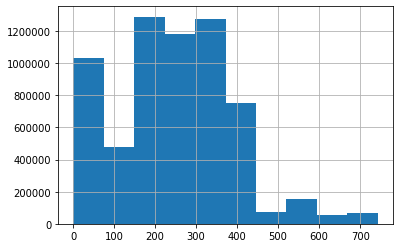

In [ ]:
df['step'].hist()

#### (ii). amount


Amounts are skewed right—the vast majority of transactions are low amounts.

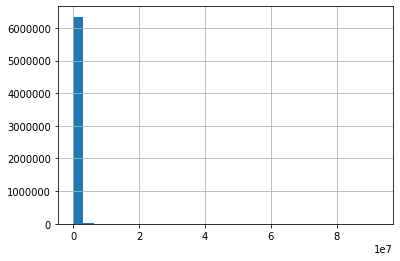

In [ ]:
df['amount'].hist(bins=30)

In [ ]:
print('The average transaction amount is',df['amount'].mean())

The average transaction amount is 179861.90354912292


#### (iii). type

For transaction type, cash withdrawals and payment transactions are the most common, while transfers and debits make up a smaller fraction of the data.

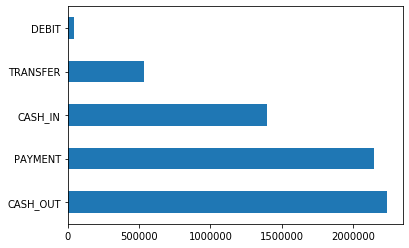

In [ ]:
df['type'].value_counts().plot(kind='barh')

#### (iv). oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest

Balance numbers show patterns similar to amount, i.e. heavily skewed to the right. We will touch on correlation between these variables next.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C341D3D828>,
      dtype=object)

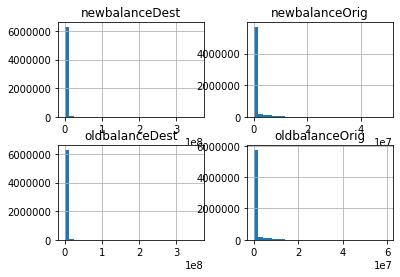

In [ ]:
df[['oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].hist(bins=30)

In [ ]:
print('Average balance values:')

with pd.option_context('display.float_format','{:.2f}'.format):
    print(df[['oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].mean())

Average balance values:
oldbalanceOrig    833883.10
newbalanceOrig    855113.67
oldbalanceDest   1100701.67
newbalanceDest   1224996.40
dtype: float64


### Feature Correlations

Let's look at correlation between the independent variables. Do any features follow similar patterns?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

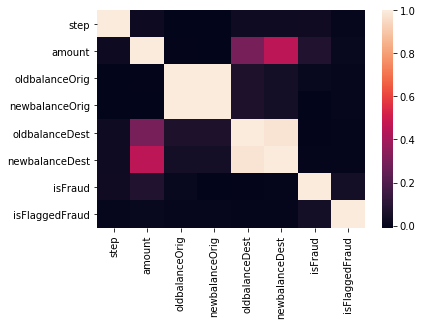

In [ ]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Given an account, oldbalance* and newbalance* are highly correlated with each other. That makes sense, because transaction amounts are typically a small proportion of account balances. In other words, account balances have high correlations with themselves.

What's odd is that while amount has some correlation with oldbalanceDest and newbalanceDest, it has very low correlations with oldbalanceOrig and newbalanceOrig. Let's check pairwise scatterplots for these variables, starting with amount vs. oldbalanceOrig and newbalanceOrig.

C:\Users\pavilion\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


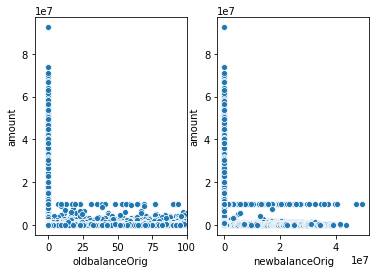

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].set_xlim([-10,100])

sns.scatterplot(data=df, x='oldbalanceOrig', y='amount', ax=ax[0])
sns.scatterplot(data=df, x='newbalanceOrig', y='amount', ax=ax[1])

fig.show()

Some interesting patterns here. There is a notably high frequency of transactions with the amount of exactly 10,000,000.

In [ ]:
# Mode of amount values
df['amount'].mode()[0]

10000000.0

There are also quite a few transactions where the amount is greater than 10,000,000, along the left edge of the scatter plots. These transactions are exclusively transfers where the destination account receives the change of the transaction amount and the originating account field has zero balance. None of these transactions are labeled as fraudulent.

In [ ]:
# What are the types of transactions for those with amounts greater than 10,000,000?
df[df['amount']>10000000]['type'].value_counts()

TRANSFER    2443
Name: type, dtype: int64

In [ ]:
# Are any of these transactions fraudulent?
df[df['amount']>10000000]['isFraud'].value_counts()

0    2443
Name: isFraud, dtype: int64

In [ ]:
df[df['amount']>10000000].head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3591182,262,TRANSFER,23695249.33,C837745698,0.0,0.0,C817622325,37522324.82,61217574.14,0,0
3592661,262,TRANSFER,14291816.93,C1719653359,0.0,0.0,C1366830412,21552410.56,35844227.49,0,0
3610921,267,TRANSFER,24288781.97,C1666560485,0.0,0.0,C1320946922,28009319.23,52298101.20,0,0
3611293,273,TRANSFER,11376816.99,C1487422082,0.0,0.0,C755537803,12699981.88,24076798.87,0,0
3611622,273,TRANSFER,35797147.01,C292308787,0.0,0.0,C817622325,61217574.14,97014721.15,0,0


Below, we can see in these pairwise plots between amount and oldbalanceDest / newbalanceDest that they exhibit more evenly random distributions. There appears to be a very weak positive relationship between amounts and destination account balances, which we observed earlier in the correlation matrix.

C:\Users\pavilion\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


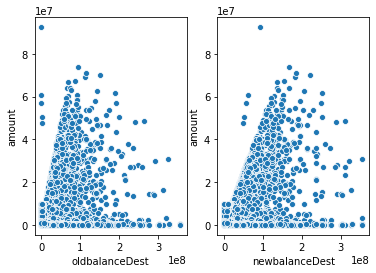

In [ ]:
fig, ax = plt.subplots(1,2)

sns.scatterplot(data=df, x='oldbalanceDest', y='amount', ax=ax[0])
sns.scatterplot(data=df, x='newbalanceDest', y='amount', ax=ax[1])

fig.show()

### Feature Enggineering

We can create some additional columns derived from existing data for features that may improve the model performance.

#### Merchant Accounts

As stated earlier, merchant account numbers are denoted by the 'M' prefix. We will capture this information in a boolean variable that the model can use as a feature.

In [ ]:
df['merchant'] = df['nameDest'].str.contains('M')

df.head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,True
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,True
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,False
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,True
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,True
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,True
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,True
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,True
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,False


#### What else is different about the fraudulent transactions?

In [ ]:
df[df['isFraud']==1].head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,False
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,0,False
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0,False
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,0,False
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0,False
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,0,False
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,0,False
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0,False
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,0,False


All fraudulent transactions fall under the CASH_OUT or TRANSFER type.

In [ ]:
# Counts of each transaction type for fraudulent transactions
df[df['isFraud']==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

As described in the dataset documentation, these transactions typically involve the fraud agent pulling large amounts out of the targeted accounts. Let's see if we can demonstrate some of these characteristics by creating and observing columns that show the change in account balances due to a transaction. We will use the convention of subtracting old balance from new, so that the difference value is positive if the account balance is higher after the transaction, and vice versa

In [ ]:
df['balancediffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['balancediffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

df.head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchant,balancediffOrig,balancediffDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,True,-9839.64,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,True,-1864.28,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,False,-181.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,False,-181.00,-21182.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,True,-11668.14,0.00
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,True,-7817.71,0.00
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,True,-7107.77,0.00
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,True,-7861.64,0.00
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,True,-2671.00,0.00
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,False,-5337.77,-1549.21


In the box plots below, we can see that between the fraudulent and non-fraudulent data, balancediffOrig shows very contrasting distributions. For isFraud==1, the values tend to be much more negative, implying that these transactions are indeed moving large amounts of funds out of the originating account. This feature could end up having significant impact on the model predictions.

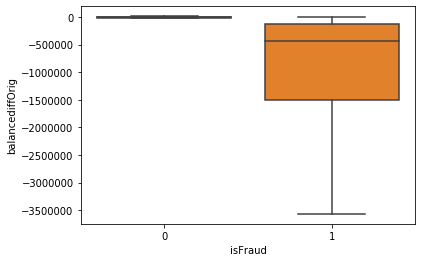

In [ ]:
sns.boxplot(x="isFraud", y="balancediffOrig", data=df,showfliers=False)

The difference is less stark with balancediffDest, and the difference values also tend to be more positive, indicating that the transactions tend to move funds into the destination account.

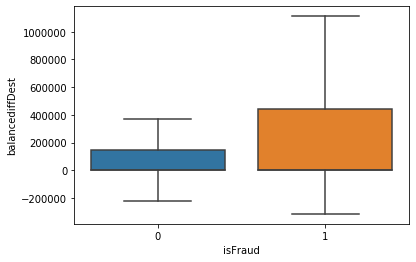

In [ ]:
sns.boxplot(x="isFraud", y="balancediffDest", data=df, showfliers=False)

A commonality in these last two plots was that the balance difference values for isFraud==1 had more variance and spread. This may be because our sample size for fraudulent data is much smaller. By nature, smaller samples are likely to exhibit higher variability.

### Preprocessing

We will now prepare the data for model input. Let's subset the dataframe to only select the variables we will use as model features, as well as the label for classification.

In [ ]:
features = ['step',
            'type',
            'amount',
            'oldbalanceOrig',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest',
            'balancediffOrig',
            'balancediffDest',
            'merchant']

label = ['isFraud']

In [ ]:
X = df[features]
y = df[label]

In [ ]:
# Before encoding
X.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,balancediffOrig,balancediffDest,merchant
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,True
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,True
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,False
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,False
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,True


### One-Hot Encoding

type is a categorical variable, which will need to be encoded as separate boolean dummy variables for each unique value of account type to be used by the model.

In [ ]:
# After encoding (scroll right to see new columns)
X = X.join(pd.get_dummies(X[['type']], prefix='type')).drop(['type'], axis=1)
X.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,balancediffOrig,balancediffDest,merchant,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,True,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,True,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,False,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,False,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,True,0,0,0,1,0


### Modeling

We will first split the data into training and test sets, with a 70/30 split. This is done to measure and avoid possible overfitting, an issue in which the model is too specific to the dataset it trains on, and is not as generalizable to out-of-sample data. By measuring the model's performance on separate data, we have a more fair assessment of the model's ability to extrapolate its predictions to new or unseen information.

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4453834, 14)
(4453834, 1)
(1908786, 14)
(1908786, 1)


#### Decision Tree

At a high level, a decision tree model works by sequentially splitting the dataset along value thresholds of the predictor variables. The splits are determined by a criteria that quantifies how different two sets of data are (by default, Gini impurity). For example, if fraudulent transactions most frequently occur with amounts over 1,000,000, while non-fraudulent transactions are more frequently of lower amounts, our decision tree is likely to use amount as a node that splits our dataset into transactions of those over 1,000,000 and those that are less. The decision tree then considers each of those two groups and attempts to perform another split on one of the other features, and so on, until the split groups have zero impurity (all the members of each group have the same classification). While in actuality the data does not contain such explicit separations, this is the general logic used by the algorithm. In a basic sense, it can be thought of as categorizing the data based on its features. It repeats the process iteratively on each branch until an end (leaf) is reached, hence the "tree".

An advantage of using decision trees is that the results are highly interpretable and easy to visualize. This means we will be able to see exactly how the decision tree constructs itself, and what features it prioritizes in its construction. It will show us how the data is being split and by what values for each feature will lead to a certain classification. The same cannot be said for certain "black box" methods of modeling, such as neural networks—which despite their potential for high performance, are often too complex to be intuitively understood and explained, even by the model developer.

Let's implement the decision tree and measure its performance.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=1)

dt_clf = dt_clf.fit(X_train,y_train)

y_pred = dt_clf.predict(X_test)

Now that the model has been fit, we can create predictions for the test set and see how they compare to the actual data. A sample of the predictions can be seen below.

In [ ]:
result = pd.DataFrame({'actual':y_test['isFraud'], 'predicted':y_pred})
result[result['actual']==1]

,actual,predicted
637351,1,0
3434399,1,1
3137121,1,1
1069777,1,1
6259961,1,1
6166140,1,1
6065199,1,1
2571515,1,1
6261323,1,1
6027400,1,1


Let's look at some metrics commonly used for measuring model performance. The sklearn.metrics.classification_report function gives us a nice printout for assessing performance, including precision, recall, and f1-score for each of the classes independently. The separation for the classes is important especially when dealing with imbalanced data, as we are now. All of these metrics range from 0 to 1, higher numbers representing better accuracy.

* Precision: The proportion of values selected by the model that should be selected. Precision is penalized by having more false positives.
* Recall: The proportion of values that should be selected, that are actually selected by the model. Recall is penalized by having more false negatives.
* F1 score: The harmonic mean of precision and recall.

Another measure we can use is Area Under Curve (AUC), which refers to the area under the ROC curve, which is a plot of the true positive rate against the false positive rate. AUC also ranges from 0 to 1 and is frequently used as a quick way to compare model performance.

In [ ]:
from sklearn import metrics 

In [ ]:
print(metrics.classification_report(y_test, y_pred))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('AUC:', metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.88      0.87      0.88      2468

    accuracy                           1.00   1908786
   macro avg       0.94      0.94      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC: 0.9371168999215428


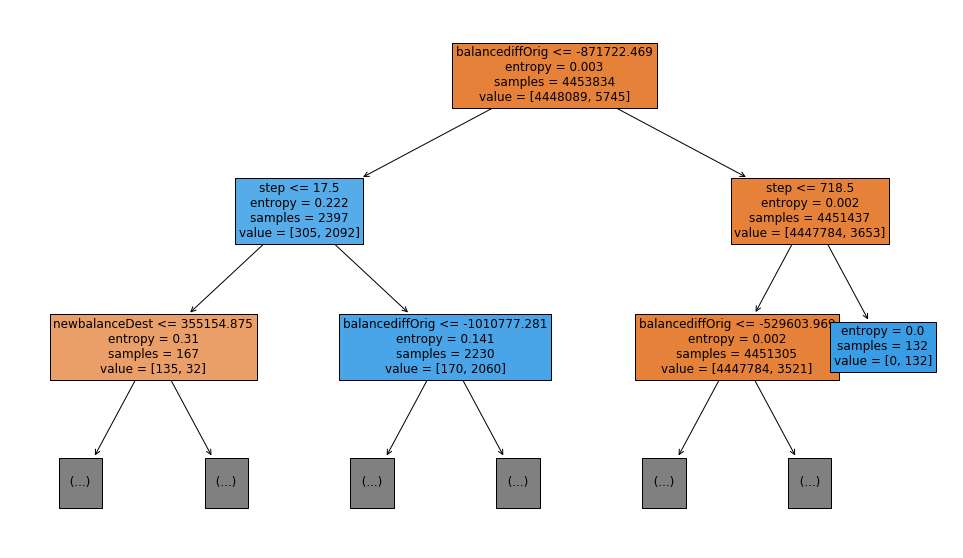

In [ ]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(17,10))
_ = plot_tree(dt_clf, max_depth=2, feature_names=list(X_train.columns), filled=True, fontsize=12)

In order to objectively determine each features' influence on the predictions, we can calculate, summed up for each feature, the amount by which it reduces impurity in each node it represents. Sklearn provides these values in the feature_importances_ attribute of DecisionTreeClassifier.

In [ ]:
fi = pd.DataFrame({'features':X_train.columns,'importance':dt_clf.feature_importances_}).sort_values(by=['importance'], ascending=False)
fi

,features,importance
6,balancediffOrig,0.405893
5,newbalanceDest,0.152945
7,balancediffDest,0.091866
13,type_TRANSFER,0.086673
1,amount,0.081542
0,step,0.063562
2,oldbalanceOrig,0.048047
3,newbalanceOrig,0.029842
10,type_CASH_OUT,0.020618
4,oldbalanceDest,0.019012


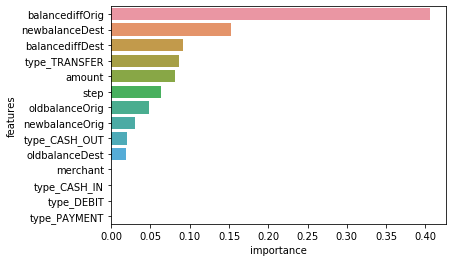

In [ ]:
sns.barplot(x="importance", y="features", data=fi)

### Potential Improvements
We have established a basic process for exploratory data analysis and modeling that has resulted in an acceptable predictor for our transaction data. While I will end our work here, there are other modeling techniques that we could try, such as SVM and Logistic Regression. There are also additional techniques to increase model performance, as well as better ways to measure performance, such as hyper-parameter tuning and cross-fold validation. It would be prudent to use these methods if we were tasked with informing business decisions that could affect large amounts of revenue or costs